In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from generator import RoadNetwork
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm

from models import Toast

In [4]:
# load dataset and bring it in format for toast
network = RoadNetwork()
network.load("../../osm_data/porto")
# df = pd.read_csv("../datasets/trajectories/Porto/road_segment_map_final.csv", sep=";", usecols=["id", "cpath"])

In [3]:
print(network.gdf_nodes.shape)
#dG = nx.DiGraph(network.G)
dG = nx.line_graph(network.G, create_using=nx.DiGraph)
index = np.arange(len(list(dG.nodes)))
nx.set_node_attributes(dG, dict(zip(list(dG.nodes), index)), name="index")


(5358, 6)


In [5]:
torch.cuda.is_available()

True

In [43]:
network.gdf_edges.loc[[(25503936, 4722746638, 0), (25503936, 4722746638, 0)]]["highway_enc"].tolist()
print(len(network.line_graph.nodes))

11331


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
toast = Toast(data=None, device=device, network=network)
toast.train(epochs=25, num_walks=20)

Random walks - T=0.16s


KeyboardInterrupt: 

In [8]:
toast = Toast(dG, network.gdf_edges)
toast.load_model("../model_states/toast/model_rw_init_epoch3.pt")

In [83]:
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

X = toast.load_embed()[2:] # embedding for each node
# train simple classifier on 80% of data with cross validation
y = np.array([network.gdf_edges.loc[n]["highway_enc"] for n in dG.nodes])

mask = ((y==11) | (y==10) | (y==9) | (y==4) | (y==1) | (y==2) | (y==12) | (y==7)) # remove uncommon tags
X = X[~mask, :]
y = y[~mask]
print(np.unique(y, return_counts=True))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size= 0.2, random_state = 1)

print('X_train dimension= ', X_train.shape)
print('X_test dimension= ', X_test.shape)
print('y_train dimension= ', y_train.shape)
print('y_test dimension= ', y_test.shape)

(array([0, 3, 5, 6, 8]), array([1680,  577, 5832, 1451, 1213]))
X_train dimension=  torch.Size([8602, 128])
X_test dimension=  torch.Size([2151, 128])
y_train dimension=  (8602,)
y_test dimension=  (2151,)


In [84]:
lm = linear_model.LogisticRegression(multi_class="multinomial", max_iter=1000)
lm.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [85]:
print(metrics.classification_report(y_test, lm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.17      0.28       343
           3       1.00      0.07      0.14       121
           5       0.57      0.98      0.72      1135
           6       0.73      0.21      0.33       305
           8       0.57      0.05      0.10       247

    accuracy                           0.58      2151
   macro avg       0.73      0.30      0.31      2151
weighted avg       0.65      0.58      0.49      2151



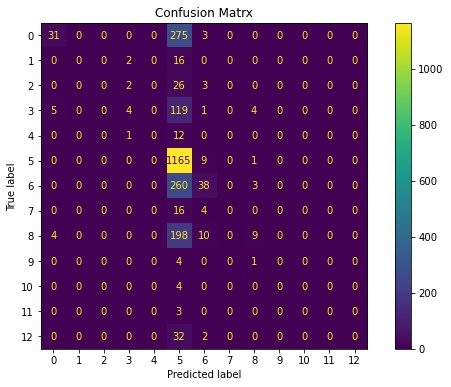

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx')

disp = metrics.plot_confusion_matrix(lm, X_test, y_test, ax = ax)